In [1]:
import os
import re
from pathlib import Path
import numpy as np
import pandas as pd
from PIL import Image
import random

#Create and load dataset
import h5py

#Deep Learning/Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

#Learning Curve
from sklearn.model_selection import learning_curve

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# metrics
from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision

In [2]:
# directories and filepaths
data_dir = Path(os.path.join(os.getcwd(),'data'))
base_dir = Path(os.path.join(data_dir, "state-farm-distracted-driver-detection"))
img_folder = Path(os.path.join(base_dir, 'imgs'))
train_imgs = Path(os.path.join(img_folder, 'train'))
test_imgs = Path(os.path.join(img_folder, 'test'))
# load the image lists
df = pd.read_csv(os.path.join(base_dir, 'driver_imgs_list.csv'))
sample_sub = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))

In [17]:
# hdf5 filename 

# CHANGED FILENAMES TO INCLUDE GRAY OR COLOR 
#(THIS WILL BE A DIFF WITH THE LEAKAGE DATASETS THAT DIDNT HAVE DRIVER INFO)
downscale = 2
gray_scale=False
if gray_scale:
    hdf5_train = f"StateFarm_Train_Gray_{downscale}X.h5"
else:
    hdf5_train = f"StateFarm_Train_Color_{downscale}X.h5"

if gray_scale:    
    hdf5_test = f"StateFarm_Test_Gray_{downscale}X.h5"
else:
    hdf5_test = f"StateFarm_Test_Color_{downscale}X.h5"
#"StateFarm_Train_2X.h5" # scaled down by 2
#"StateFarm_Train_5X.h5" # scaled down by 5 

## Split data, get out Train and Validation

In [4]:
str2int = lambda istr: int(re.findall('\d+', istr)[0])

def split_on_driver(df, train_split=.8,  seed=0):
    # splits dataframe based on drivers
    # take in dataframe (original), train_split proportion,  random seed
    # returns new dataframe, train_drivers,  test_drivers
    
    # if dataframe doesn't already have driver, addit 
    if 'driver' not in df.columns:
        df['driver'] =  df.subject.apply(str2int) # SID FOR SUBJECT ID
        df['class'] = df.classname.apply(str2int) # 
   
    # random number generator
    rng = np.random.default_rng(seed=seed) 
    
    # unique drivers and number of drivers
    drivers = np.unique(df['driver'].values)
    ndrivers = len(drivers)
    
    # number of data pts per driver 
    nPerDriver = df.groupby('driver').count().values
    nPerDriver = nPerDriver[:,0]
    
    # shuffle drivers (get shuffle indices)
    shuff_idx  = rng.permutation(ndrivers)
    
    # shuffle the drivers and the nPerDriver according to shuffle indices
    drivers = drivers[shuff_idx]
    nPerDriver = nPerDriver[shuff_idx]
    
    # separate drivers according to train_split
    train_log = np.cumsum(nPerDriver) < (22424*train_split) # really close to 20/80 plit (e.g. splits at 17891, 80% is 17939)
    test_log = np.logical_not(train_log)
    train_drivers = drivers[train_log]
    test_drivers = drivers[test_log]
    
    return (df, train_drivers, test_drivers, nPerDriver)

### load dataframe (from csv) and load hd5 file

In [19]:
# load data set
# load the dataframe
df = pd.read_csv(os.path.join(base_dir, 'driver_imgs_list.csv'))
# Open the HDF5 file
file = h5py.File(data_dir / hdf5_train, "r+")
images = np.array(file["/images"]).astype("uint8")
classes = np.array(file["/c"]).astype("uint8")
drivers = np.array(file["/driver"]).astype("uint8")
file.close()

In [71]:
# make data matrix X 
image_size = images.shape[1:]
# Resize images as vectors
# X = images.reshape(images.shape[0], images.shape[1]*images.shape[2])
# Zero mean 
# X = X - X.mean(axis=1).reshape(X.shape[0], 1)

# split the training and validation data
df, train_drivers, test_drivers, nPerDriver = split_on_driver(df, train_split=.8,  seed=0)
train_log = [d in train_drivers for d in drivers]
test_log = [d in test_drivers for d in drivers]

Xtrain = images[train_log, ...]
Ytrain = classes[train_log]

Xval = images[test_log,...]
Yval = classes[test_log] 

In [21]:
Xtrain.shape

(17873, 240, 320, 3)

In [22]:
Xval.shape

(4551, 240, 320, 3)

In [ ]:
# sort labels by filename 

### Set up data augmentation

In [16]:
from keras.preprocessing.image import ImageDataGenerator

In [70]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range= 20, 
    height_shift_range = 0.05, 
    width_shift_range = 0.05,
    horizontal_flip = True,
)
train_gen = datagen.flow(Xtrain, Ytrain, batch_size=32)


NameError: name 'Xtrain' is not defined

In [38]:
x,y = next(train_gen)

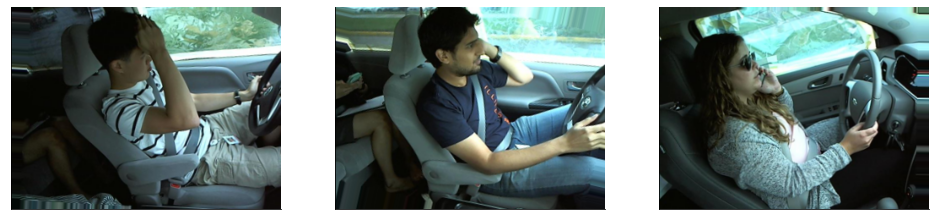

In [64]:
randinds = np.random.choice(32, 3)
plt.figure(figsize=(15,9))
plt.subplot(131)
plt.imshow(x[randinds[0],...]);
plt.xticks([])
plt.yticks([])
plt.subplot(132)
plt.imshow(x[randinds[1],...]);
plt.xticks([])
plt.yticks([])

plt.subplot(133)
plt.imshow(x[randinds[2],...]);
plt.xticks([]);
plt.yticks([]);



# Define the model